# Introduction

This is the live coding challenge for Docsumo Interview related to Data Science(DS) or Machine Learning (ML)

You will be provided dataset and barebone code. You have to write on top of that.

You will be assessed based on:    
- problem-solving skills
- quality of code ("quality" means how efficient your code is compard to existing one. Are there any side-effects of your code?)

In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import skimage.io

In [2]:
import copy
import io
import requests

from typing import List, Tuple, Union

# Task 1:
The following code takes long time to execute for larger dataset. How would you make it faster.

In [3]:
def compute_similarity(vector1:list, vector2:list) -> float:
    """
        This function is inefficient for a very large vector (say if vector dimension is 1 million).
        Also, it has a bug. Detect that.
    """
    s = 0
    for v1, v2 in zip(vector1, vector2):
        s += v1 * v2
    l1 = sum(map(lambda x: x**2, vector1)) ** 0.5
    l2 = sum(map(lambda x: x**2, vector2)) ** 0.5
    return s / (l1 * l2)

In [8]:
def compute_similarity_modified(vector1:list, vector2:list) -> float:
    """
        This function is inefficient for a very large vector (say if vector dimension is 1 million).
        Also, it has a bug. Detect that.
    """
    dot_product = vector1 @ vector2
    a = np.linalg.norm(vector1)
    b = np.linalg.norm(vector2)
    if a==0 or b==0:
      return 0
      
    return (dot_product/(a*b))

In [4]:
N = 10000000
vector1 = np.random.random(N)
vector2 = np.random.random(N)

In [5]:
compute_similarity(vector1, vector2)

0.7499106869008719

In [7]:
compute_similarity_modified(vector1, vector2)

0.749910686900871

# Task 2

*Create* a decorator to log time performance of those functions.

## Example usage
```python

@perf_logger
def search_df(bbox: tuple) -> pd.DataFrame:
    ...
```

Create a time performance logger that can also take parameters for unit of time (seconds? minutes? hours?)

```python
@perf_logger(unit="seconds")
def search_df(bbox: tuple) -> pd.DataFrame:
    ...
```

In [28]:
from time import time

def perf_arg(unit):
  def pref_logger(func):
    def wrapper_func(*args, **kwargs):
      start_time = time()
      result = func(*args, **kwargs)
      end_time = time()
      total_time_taken = end_time - start_time
      print(f"Total time taken : {total_time_taken: .2f} {unit}") 
      return result
    return wrapper_func
  
  return pref_logger

In [29]:
@perf_arg("seconds")
def compute_similarity_modified(vector1:list, vector2:list) -> float:
    """
        This function is inefficient for a very large vector (say if vector dimension is 1 million).
        Also, it has a bug. Detect that.
    """
    dot_product = vector1 @ vector2
    a = np.linalg.norm(vector1)
    b = np.linalg.norm(vector2)
    if a==0 or b==0:
      return 0
      
    return (dot_product/(a*b))

In [30]:
compute_similarity_modified(vector1, vector2)

Total time taken :  0.04 seconds


0.749910686900871

# Conventions

- When we say "BBox", it represents a rectangular region (list/tuple) with 4 elements ``[x0, y0, x2, y2]``. `x0` and `y0` represent top-left corner. `x2` and `y2` represent bottom-right.

In [31]:
CSV_PATH = "https://raw.githubusercontent.com/docsumo/docudata/dev/samples/data_1.csv"
IMG_PATH = "https://raw.githubusercontent.com/docsumo/docudata/dev/samples/data_1.jpg"

# Loaders

These are utility functions to download the required data

In [32]:
def load_df(path) -> pd.DataFrame:
    """
        Load dataframe from URL or local path
    """
    if path.startswith("http"):
        s = requests.get(path).content
        path = io.StringIO(s.decode('utf-8'))
    return pd.read_csv(path)

In [33]:
def load_image(path) -> np.ndarray:
    """
        Load image from URL or local path
    """
    return skimage.io.imread(path)

# Debuggers / Painters

In [34]:
def draw_bboxes(
    img: np.ndarray,
    bboxes: Union[List[Tuple[int, int, int, int]], List[int]],
    linewidth=5,
    color: Tuple[int, int, int] = (0, 0, 255),
) -> np.ndarray:
    """
        Draw rectangle in the image from the list of bboxes.
    """
    canvas = img.copy()
    bboxes = copy.deepcopy(bboxes)
    for bbox in bboxes:
        if not isinstance(bbox, tuple):
            bbox = tuple(bbox)
        canvas = cv2.rectangle(
            canvas, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, linewidth
        )
    return canvas

def show_image(img: np.ndarray, size=(20, 15)) -> None:
    """
        This plots the input image through matplotlib plot api.
    """
    plt.figure(figsize=size)
    if img.ndim == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Visualization

In [35]:
df = load_df(CSV_PATH)
img = load_image(IMG_PATH)

In [36]:
df.head()

,index_sort,page,block,line,x0,y0,x2,y2,Text,space_type,confidence
0,0,0,0,0,60,58,200,91,Account,1,0.995714
1,1,0,0,0,221,58,297,91,Name,2,0.995000
2,2,0,0,0,309,58,314,91,:,1,0.940000
3,3,0,0,0,341,58,419,91,Mary,1,0.925000
4,4,0,0,0,443,58,518,91,Jane,1,0.997500


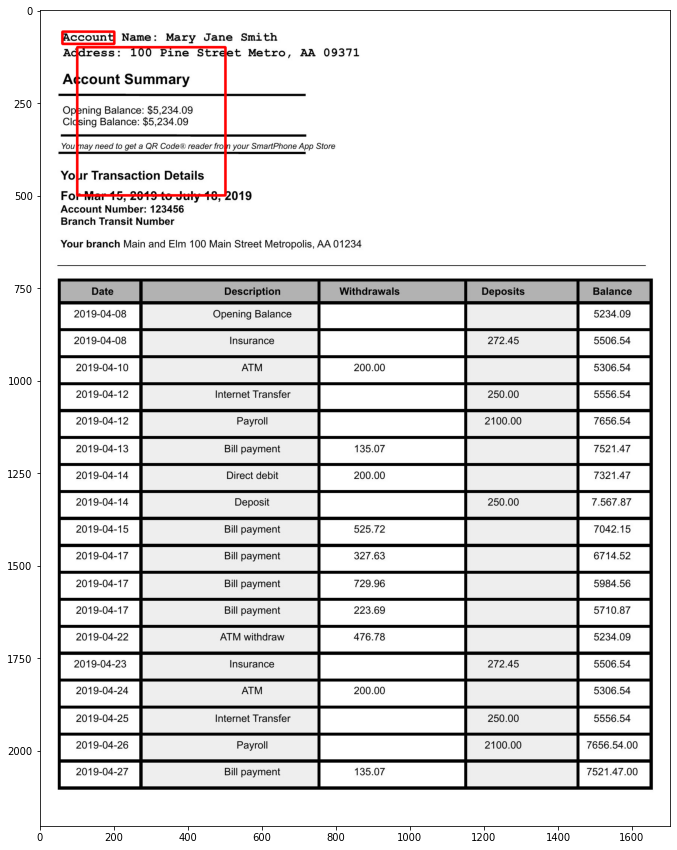

In [37]:
canvas = draw_bboxes(img, bboxes=[(100, 100, 500, 500), (60, 58, 200, 91)])
show_image(canvas)

# bbox-based filter

In the dataframe `DF`, search all the rows and text that lies within a bbox region.

**Use Case:** 

In docsumo platform we allow user to draw box to extract text for a given region. User may draw very precise or somtimes low precise boxes. Regardless of the case we should give appropriate text as output